In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import folium
from folium import Choropleth
import geopandas as gpd

sns.set_style("whitegrid")
sns.set_context('poster')
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)

In [ ]:
#Parameters
country="LU"

# Data

## Migration Data - Raw

In [ ]:
from eurostatapiclient import EurostatAPIClient

#Set versions and formats, so far only the ones used here are availeable and call client
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In [ ]:
countries_names = {'AT':'Austria', 'BE':'Belgium', 'BG':'Bulgaria', 'CY': 'Cyprus', 
                   'CZ': 'Czechia', 'DE': 'Germany', 'DK': 'Denmark', 'EE':'Estonia', 
                   'EL': 'Greece', 'ES':'Spain', 'FI':'Finland', 'FR':'France', 
                   'HR':'Croatia', 'HU':'Hungary', 'IE':'Ireland', 'IT':'Italy', 
                   'LT':'Lithuania', 'LU':'Luxembourg', 'LV':'Latvia', 'MT': 'Malta', 
                   'NL':'Netherlands', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 
                   'SE':'Sweden', 'SI':'Slovenia', 'SK':'Slovakia', 'UK':'United Kingdom'}

In [ ]:
df = []
for sex in ['M', 'F']:
    for age in ['TOTAL', 'Y_GE65', 'Y_LT15']:
        par_df = {
            'agedef': 'REACH',
            'sex': sex,
            'unit': 'NR',
            'geo': list(countries_names.keys()),
            'c_birth': list(countries_names.keys()),
            'age': age}

        df.append(client.get_dataset('migr_imm3ctb', params=par_df).to_dataframe())

In [ ]:
df = pd.concat(df, axis=0)

In [ ]:
df.sample(10)

,values,age,agedef,c_birth,unit,sex,geo,time
2565,1749.0,TOTAL,REACH,ES,NR,M,NL,2017
1974,NaN,TOTAL,REACH,EE,NR,F,IE,2014
510,10.0,Y_LT15,REACH,BG,NR,F,LU,2014
2203,13.0,Y_LT15,REACH,FR,NR,F,HU,2015
5473,129.0,TOTAL,REACH,NL,NR,M,RO,2009
4700,0.0,Y_GE65,REACH,SE,NR,F,HU,2016
3279,70.0,TOTAL,REACH,HR,NR,F,HU,2011
925,NaN,Y_LT15,REACH,CZ,NR,M,SE,2009
840,NaN,Y_LT15,REACH,CZ,NR,M,HR,2008
302,21.0,TOTAL,REACH,BE,NR,F,CZ,2010


## Migration Data - Processed

### Ballast Drop

In [ ]:
df.drop('agedef', axis=1, inplace=True)
df.drop('unit', axis=1, inplace=True)

In [ ]:
df[(df['geo']==country) & (df['time']=='2018') & (df['c_birth']=='BE')]

,values,age,c_birth,sex,geo,time
430,639.0,TOTAL,BE,M,LU,2018
322,27.0,Y_GE65,BE,M,LU,2018
322,76.0,Y_LT15,BE,M,LU,2018
430,507.0,TOTAL,BE,F,LU,2018
322,25.0,Y_GE65,BE,F,LU,2018
322,98.0,Y_LT15,BE,F,LU,2018


### NaN Handling

In [ ]:
df = df.pivot(
    index=['c_birth', 'geo', 'time', 'sex'],
    columns=['age'],
    values='values')

In [ ]:
df.sample(5)

,,,age,TOTAL,Y_GE65,Y_LT15
c_birth,geo,time,sex,,,
EL,NL,2019,F,1361.0,4.0,109.0
LV,HR,2019,M,6.0,0.0,1.0
PT,SK,2010,F,NaN,NaN,NaN
CZ,BG,2016,M,12.0,0.0,4.0
EL,NL,2019,M,1855.0,6.0,133.0


Replaced NaN by zero (0)

In [ ]:
df.fillna(0, inplace=True)

In [ ]:
df.sample(5)

,,,age,TOTAL,Y_GE65,Y_LT15
c_birth,geo,time,sex,,,
ES,HU,2014,F,127.0,0.0,8.0
SI,AT,2016,F,859.0,0.0,0.0
UK,RO,2017,M,68.0,0.0,0.0
SI,SE,2016,M,43.0,0.0,5.0
LU,LU,2014,F,606.0,46.0,161.0


### Age Classification

- children: immigrants listed younger than 15
- elderly: immigrants listed 65 and older
- working-population: Total number of immigrants minus children and elderly

In [ ]:
df['children'] = df['Y_LT15']
df['working-age'] = df['TOTAL'] - df['Y_LT15'] - df['Y_GE65']
df['elderly'] = df['Y_GE65']

df.drop(['TOTAL', 'Y_GE65', 'Y_LT15'], axis=1,inplace=True)

In [ ]:
df.head(5)

age                   children  working-age  elderly
c_birth geo time sex                                
AT      AT  2008 F         0.0       2489.0      0.0
                 M         0.0       4373.0      0.0
            2009 F         0.0          0.0      0.0
                 M         0.0          0.0      0.0
            2010 F         0.0          0.0      0.0

In [ ]:
df = df.reset_index().melt(
    id_vars=['c_birth', 'geo', 'time', 'sex'],
    value_vars=['children', 'elderly', 'working-age'])

In [ ]:
df.sample(10)

,c_birth,geo,time,sex,age,value
10684,NL,EE,2010,F,children,0.0
40948,PL,IT,2010,F,working-age,5527.0
18149,DK,FR,2010,M,elderly,0.0
25625,NL,IE,2016,M,elderly,0.0
30540,BE,SE,2014,F,working-age,62.0
43010,SI,HU,2009,F,working-age,9.0
25911,PL,BE,2015,M,elderly,12.0
26951,RO,AT,2019,M,elderly,0.0
35736,FR,LV,2008,F,working-age,0.0
39901,MT,IT,2014,M,working-age,17.0


### Name Mapping

In [ ]:
df.rename(columns={'geo': 'country of arrival', 'c_birth': 'country of birth', 'value': 'immigrants', 'time': 'year'}, inplace=True)
df['year'] = df['year'].astype('int')
df['country of birth'] = df['country of birth'].map(countries_names)
df['country of arrival'] = df['country of arrival'].map(countries_names)
country = countries_names[country]

In [ ]:
df.sample(10)

,country of birth,country of arrival,year,sex,age,immigrants
6507,Croatia,Finland,2009,M,children,0.0
965,Belgium,Sweden,2010,M,children,0.0
5012,Spain,Hungary,2018,F,children,9.0
12278,Romania,Estonia,2015,F,children,0.0
20765,France,Finland,2010,M,elderly,0.0
34051,Greece,Hungary,2017,M,working-age,48.0
18639,Estonia,Spain,2015,M,elderly,0.0
18517,Estonia,Belgium,2014,M,elderly,1.0
28237,Slovenia,Hungary,2014,M,elderly,0.0
15514,Belgium,France,2013,F,elderly,0.0


## Geospatial Data

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    dir = os.path.join('gdrive', 'MyDrive', 'Eurostat', '01 - Intro to Python for Data Science')
else:
    dir = '.'
    
data_dir = os.path.join(dir, 'data')
os.makedirs(data_dir, exist_ok=True)
data_dir

'.\\data'

Place the content of [NUTS_RG_10M_2021_4326_LEVL_0.shp](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts) into your data_dir

In [ ]:
nuts0 = gpd.read_file(os.path.join(data_dir, 'NUTS_RG_10M_2021_4326_LEVL_0.shp'))
nuts0.dropna(axis=0, subset=['NUTS_ID'], inplace=True)
nuts0.set_index('NUTS_ID', inplace=True, drop=True)

In [ ]:
nuts0.sample(10)

,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
NUTS_ID,,,,,,,,,
RS,0,RS,Serbia,Srbija/Сpбија,0,None,0,RS,"POLYGON ((19.69810 46.18793, 19.79780 46.13588..."
MT,0,MT,Malta,Malta,0,None,0,MT,"MULTIPOLYGON (((14.32981 35.89674, 14.34307 35..."
LU,0,LU,Luxembourg,Luxembourg,0,None,0,LU,"POLYGON ((6.13766 50.12995, 6.12792 50.04735, ..."
IE,0,IE,Éire/Ireland,Éire/Ireland,0,None,0,IE,"MULTIPOLYGON (((-7.25607 55.06703, -7.34292 55..."
NO,0,NO,Norge,Norge,0,None,0,NO,"MULTIPOLYGON (((32.34947 80.08196, 31.90668 80..."
HU,0,HU,Magyarország,Magyarország,0,None,0,HU,"POLYGON ((22.12108 48.37831, 22.15531 48.40340..."
HR,0,HR,Hrvatska,Hrvatska,0,None,0,HR,"MULTIPOLYGON (((16.59681 46.47590, 16.85476 46..."
AT,0,AT,Österreich,Österreich,0,None,0,AT,"POLYGON ((15.54245 48.90770, 15.75363 48.85218..."
RO,0,RO,România,România,0,None,0,RO,"POLYGON ((27.39117 47.58940, 27.44355 47.53666..."


# Visualizations

## Immigrants by gender and age

In [ ]:
_df = df[df['country of arrival'] == country].pivot_table(
        columns=['age'],
        index=['year', 'sex'],
        values='immigrants',
        aggfunc=np.sum)

_df['<65 cumul'] = _df['children'] + _df['working-age']
_df['total'] = _df['children'] + _df['working-age'] + _df['elderly']
_df.reset_index(inplace=True)

In [ ]:
_df

age,year,sex,children,elderly,working-age,<65 cumul,total
0,2008,F,0.0,0.0,6108.0,6108.0,6108.0
1,2008,M,0.0,0.0,7614.0,7614.0,7614.0
2,2009,F,0.0,0.0,5459.0,5459.0,5459.0
3,2009,M,0.0,0.0,6518.0,6518.0,6518.0
4,2010,F,0.0,0.0,5558.0,5558.0,5558.0
5,2010,M,0.0,0.0,6876.0,6876.0,6876.0
6,2011,F,0.0,0.0,6428.0,6428.0,6428.0
7,2011,M,0.0,0.0,8077.0,8077.0,8077.0
8,2012,F,0.0,0.0,6707.0,6707.0,6707.0
9,2012,M,0.0,0.0,8266.0,8266.0,8266.0


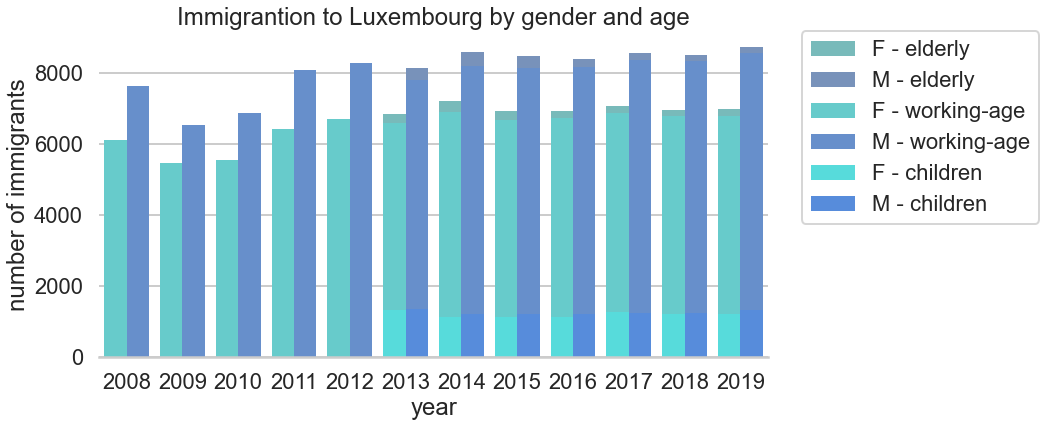

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

__df = _df.copy()
__df['sex'] = __df['sex'].map({'M': 'M - elderly', 'F': 'F - elderly'})
sns.barplot(data=__df,
            x='year',
            y='total',
            hue='sex',
            saturation=0.5, 
            linewidth=0)

__df = _df.copy()
__df['sex'] = __df['sex'].map({'M': 'M - working-age', 'F': 'F - working-age'})
sns.barplot(data=__df,
            x='year',
            y='<65 cumul',
            hue='sex',
            saturation=0.75,
            linewidth=0)

__df = _df.copy()
__df['sex'] = __df['sex'].map({'M': 'M - children', 'F': 'F - children'})
sns.barplot(data=__df,
            x='year',
            y='children',
            hue='sex',
            saturation=1,
            linewidth=0)
sns.despine(left=True, top=True, right=True)

plt.title(f"Immigrantion to {country} by gender and age")
ax.set_ylabel('number of immigrants')
ax.set_xlabel('year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

## Immigrants by country of birth

In [ ]:
_df = df[df['country of arrival'] == country].pivot_table(
        index=['country of birth'],
        values='immigrants',
        aggfunc=np.sum)

_df.index = _df.index.map({v: k for k, v in zip(countries_names.keys(), countries_names.values())})

In [ ]:
_df.sample(10)

,immigrants
country of birth,
LV,759.0
SI,588.0
NL,2392.0
DE,12111.0
UK,5190.0
HU,2000.0
IE,1392.0
BG,1853.0
SE,1384.0


In [ ]:
m = folium.Map(location=[49.63321762577624, 6.169436798146017],
               tiles='CartoDB positron',
               zoom_start=4)

Choropleth(geo_data=nuts0.__geo_interface__, 
           key_on="feature.id", 
           data=_df['immigrants'],
           fill_color='YlGnBu', 
           legend_name=f"Immigrants to Luxembourg by country of birth (2008-2019)"
          ).add_to(m)

m

In [ ]:
dominant_country_of_birth = _df.sort_values(by='immigrants', ascending=False).iloc[0].name
print(f"Most immigrants to {country} were born in {countries_names[dominant_country_of_birth]}!")

Most immigrants to Luxembourg were born in France!


# Table

In [ ]:
_df = df[df['country of arrival'] == country].pivot_table(
    values='immigrants',
    columns='year',
    index='country of birth',
    aggfunc=np.sum)

In [ ]:
print(f"The following tabe holds the annual number of immigrants to {country}, by country of birth:")

The following tabe holds the annual number of immigrants to Luxembourg, by country of birth:


In [ ]:
_df

year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
country of birth,,,,,,,,,,,,
Austria,58.0,65.0,66.0,55.0,67.0,52.0,95.0,76.0,77.0,74.0,66.0,82.0
Belgium,952.0,955.0,1059.0,1071.0,1216.0,1384.0,1490.0,1424.0,1203.0,1245.0,1146.0,1180.0
Bulgaria,162.0,108.0,101.0,144.0,122.0,98.0,172.0,179.0,211.0,189.0,187.0,180.0
Croatia,9.0,9.0,32.0,34.0,68.0,72.0,121.0,98.0,124.0,107.0,123.0,143.0
Cyprus,3.0,6.0,8.0,14.0,11.0,17.0,22.0,9.0,19.0,17.0,14.0,19.0
Czechia,114.0,95.0,92.0,108.0,80.0,62.0,83.0,101.0,77.0,83.0,79.0,76.0
Denmark,125.0,116.0,87.0,95.0,107.0,131.0,92.0,84.0,81.0,85.0,91.0,81.0
Estonia,69.0,34.0,56.0,49.0,56.0,50.0,42.0,39.0,38.0,54.0,43.0,42.0
Finland,80.0,59.0,76.0,115.0,60.0,73.0,88.0,107.0,98.0,84.0,103.0,95.0
